In [1]:
import os
import numpy as np
import keras
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
#from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetMobile
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.optimizers import RMSprop
import functools
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

In [2]:
MODEL_NAME = "M_CNN_M1_10_20.h5"
IMG_ROWS, IMG_COLS = 224, 224
INPUT_SHAPE=(224, 224, 3)
PATH = 'data/'
TRAIN_DATA_PATH = os.path.join(PATH, 'Training')
TEST_DATA_PATH = os.path.join(PATH, 'Testing')
BATCH_SIZE = 40
NUM_EPOCHS = 50
CLASS_MODE = 'categorical'
COLOR_MODE = 'rgb'
SAVE_FORMAT = 'png'


In [3]:

data_dir_list =np.sort(os.listdir(TRAIN_DATA_PATH))
data_dir_list

array(['.DS_Store', 'glioma_tumor', 'meningioma_tumor', 'no_tumor',
       'pituitary_tumor'], dtype='<U16')

In [4]:

data_dir_list_Test =np.sort(os.listdir(TEST_DATA_PATH))
data_dir_list_Test

array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
      dtype='<U16')

In [5]:
train_data_gen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.5, 
    rescale=1./255,
    vertical_flip=True, 
    validation_split=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True) 

In [6]:
train_generator = train_data_gen.flow_from_directory(
        TRAIN_DATA_PATH,
        target_size=(IMG_ROWS, IMG_COLS), 
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        color_mode=COLOR_MODE, 
        shuffle=True,   
        save_format=SAVE_FORMAT, 
        subset="training")


val_generator = train_data_gen.flow_from_directory(
    TRAIN_DATA_PATH,
    target_size=(IMG_ROWS, IMG_COLS), 
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode=COLOR_MODE, 
    shuffle=True,   
    save_format=SAVE_FORMAT, 
    subset='validation'
)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [7]:
train_generator.samples 

2297

In [8]:
train_generator.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [9]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode=COLOR_MODE, 
    shuffle = False,
    seed=None,  
    save_format=SAVE_FORMAT
)


Found 394 images belonging to 4 classes.


In [10]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [11]:
def create_vgg_model():
    
    
    conv = VGG16(input_shape= INPUT_SHAPE,weights='imagenet',include_top=False)
    conv.output


    x = conv.output
    x = GlobalAveragePooling2D()(x)


    x = Dense(1024,activation='relu')(x)
    x = Dense(1024,activation='relu')(x)
    x = Dense(1024,activation='relu')(x)
    x = Dense(1024,activation='relu')(x)
    x = Dense(512, activation='relu')(x)


    pred = Dense(4,activation='softmax')(x)
    model = Model(inputs = conv.input,outputs=pred)
    
    
    for layer in conv.layers:
        layer.trainable = False


    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy']

    )
    
    return model

In [12]:
import itertools

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

def cnn_model():
    model = Sequential()
    #
    model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu', input_shape = INPUT_SHAPE))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    #
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))
    #
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.3))
    #
    model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.3))

    #
    model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.3))

    # 
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation = "softmax"))
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [13]:
model = cnn_model()

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=NUM_EPOCHS,
    workers=6,
    max_queue_size=100,
    verbose=True,
    #callbacks=[early_stopping]
)

Epoch 1/50
58/58 [==============================] - 212s 4s/step - loss: 1.3966 - accuracy: 0.3683 - val_loss: 1.2908 - val_accuracy: 0.4171
Epoch 2/50
58/58 [==============================] - 212s 4s/step - loss: 1.1930 - accuracy: 0.4693 - val_loss: 1.2641 - val_accuracy: 0.4066
Epoch 3/50
58/58 [==============================] - 211s 4s/step - loss: 1.1438 - accuracy: 0.4963 - val_loss: 1.2181 - val_accuracy: 0.4415
Epoch 4/50
58/58 [==============================] - 211s 4s/step - loss: 0.9786 - accuracy: 0.5925 - val_loss: 1.3016 - val_accuracy: 0.4398
Epoch 5/50
58/58 [==============================] - 211s 4s/step - loss: 0.9303 - accuracy: 0.6186 - val_loss: 1.2887 - val_accuracy: 0.4136
Epoch 6/50
58/58 [==============================] - 211s 4s/step - loss: 0.8712 - accuracy: 0.6321 - val_loss: 1.3970 - val_accuracy: 0.4223
Epoch 7/50
58/58 [==============================] - 213s 4s/step - loss: 0.8243 - accuracy: 0.6548 - val_loss: 1.2755 - val_accuracy: 0.4956
Epoch 8/50
58

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       1

In [15]:
loss, accuracy = model.evaluate(test_generator)

print(f"Test Accuracy Top-1: {accuracy * 100}%")

10/10 [==============================] - 6s 589ms/step - loss: 3.1766 - accuracy: 0.4619
Test Accuracy Top-1: 46.192893385887146%


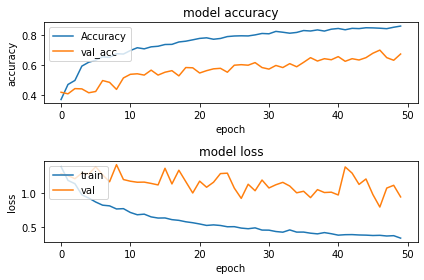

In [16]:

plt.figure(1)

# summarize history for accuracy
plt.subplot(211) 
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'val_acc'], loc='upper left')

# summarize history for loss
plt.subplot(212) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout() 
plt.savefig('acc_loss_50.pdf')
plt.show()